In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.random import randn
import os
import seaborn as sns
import keras
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose, Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# config
noise_dimension = 100
batch_size = 64
width, height, channels = 200, 200, 1

# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset
main_dir = '/content/drive/MyDrive/Healthy'

# loading the dataset => resize images to 128*128*3
images = []
for i in os.listdir(main_dir):
    img_path = os.path.join(main_dir, i)
    print(f"Loading image: {img_path}")

    img = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error loading image: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (200, 200))
    images.append(img)

dataset = np.array(images)

print(dataset.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading image: /content/drive/MyDrive/Healthy/image_007.png
Loading image: /content/drive/MyDrive/Healthy/image_019.png
Loading image: /content/drive/MyDrive/Healthy/image_014.png
Loading image: /content/drive/MyDrive/Healthy/image_033.png
Loading image: /content/drive/MyDrive/Healthy/image_005.png
Loading image: /content/drive/MyDrive/Healthy/image_024.png
Loading image: /content/drive/MyDrive/Healthy/image_004.png
Loading image: /content/drive/MyDrive/Healthy/image_037.png
Loading image: /content/drive/MyDrive/Healthy/image_017.png
Loading image: /content/drive/MyDrive/Healthy/image_015.png
Loading image: /content/drive/MyDrive/Healthy/image_016.png
Loading image: /content/drive/MyDrive/Healthy/image_008.png
Loading image: /content/drive/MyDrive/Healthy/image_023.png
Loading image: /content/drive/MyDrive/Healthy/image_036.png
Loading image: /content/drive/M

(365, 200, 200)


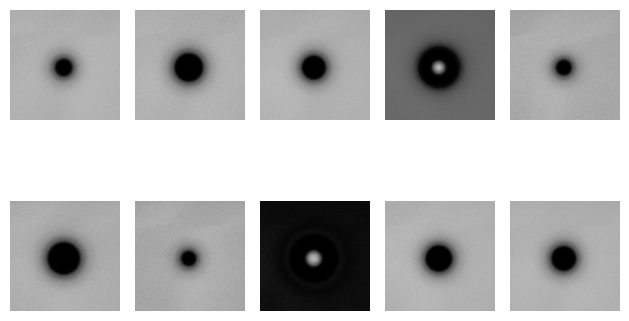

No error till now


In [ ]:
X_train = dataset

# Normalize
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
print(X_train.shape)

# Reshape
X_train = X_train.reshape(-1, width, height, channels)

# Save images to Google Colab environment
for i in range(10):
    img = np.expand_dims(X_train[i], axis=2)
    img = np.repeat(img, 3, axis=2)

    # Save images to Colab environment
    cv2.imwrite('/content/greyscale_image_{}.png'.format(i), cv2.cvtColor((img * 127.5 + 127.5).astype(np.uint8), cv2.COLOR_RGB2BGR))

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='bone')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("No error till now")


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.1 MB/s eta 0:00:00


In [ ]:
from keras.layers import Input, Add, Activation
from keras.models import Model
from keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU

def residual_block(layer_in, n_filters):
    merge_input = layer_in
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    layer_out = Add()([conv2, merge_input])
    layer_out = Activation('relu')(layer_out)
    return layer_out

def func_generator(noise_dimension):
    n_nodes = 256*50*50
    input_layer = Input(shape=(noise_dimension,))
    x = Dense(n_nodes)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((50, 50, 256))(x)
    x = Conv2DTranspose(128, (4, 4), strides=2, padding='same')(x)
    x = residual_block(x, 128)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(128, (4, 4), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    output_layer = Conv2D(1, (4, 4), padding='same', activation='tanh')(x)
    model = Model(input_layer, output_layer)
    return model

noise_dimension = 100  # Define your noise dimension
G_model = func_generator(noise_dimension)
G_model.summary()

import tensorflow_addons as tfa
from keras.optimizers import Adam
from keras.layers import Flatten, Dropout
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU

def func_discriminator():
    model = Sequential([
        tfa.layers.SpectralNormalization(Conv2D(64, (3, 3), padding='same',input_shape=(width, height, channels))),
        LeakyReLU(alpha=0.2),

        tfa.layers.SpectralNormalization(Conv2D(128, (3, 3), strides=2, padding='same')),
        LeakyReLU(alpha=0.2),

        tfa.layers.SpectralNormalization(Conv2D(128, (3, 3), strides=2, padding='same')),
        LeakyReLU(alpha=0.2),

        tfa.layers.SpectralNormalization(Conv2D(256, (3, 3), strides=2, padding='same')),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid")])

    model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model
# Define your input shape
input_shape = (None, width, height, channels)

D_model = func_discriminator()
D_model.build(input_shape)  # Build the model
D_model.summary()  # Now this should work

def real_samples(dataset, n_samples):
    # choose random images
    indx = np.random.randint(0, dataset.shape[0], n_samples) # dataset.shape = 155
    X = dataset[indx]
    # generate class labels
    y = np.ones((n_samples, 1)) # label 1 to fool discriminator that they are real
    return X, y

# generate points
def generate_latent_points(noise_dimension, n_samples):
    x_input = randn(noise_dimension * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, noise_dimension)
    return x_input

def fake_samples(generator, noise_dimension, n_samples):
    X_input = generate_latent_points(noise_dimension, n_samples) # generating points in latent space
    X = generator.predict(X_input) # generating fake samples
    y = np.zeros((n_samples, 1))  # labels 0 as these samples are fake
    return X, y

# the combined generator and discriminator model, for training and updating the generator
# Discriminator is trained separately (remain constant)
def gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005, beta_1=0.5))
    return model

def show_plot(examples, n, t=0):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        imgg = cv2.cvtColor(examples[i, :, :, :], cv2.COLOR_GRAY2BGR)
        plt.title(f'epoch {t}')
        # plt.imsave(f'D:\Habib\High resolutation GAN\Inpainting GAN\GAN image creator\Images\epoch_{t}.png', imgg,cmap="bone")
        plt.imshow(examples[i, :, :, :],cmap="bone")
    plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 640000)               6464000   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)  (None, 640000)               0         ['dense_4[0][0]']             
                                                                                                  
 reshape_2 (Reshape)         (None, 50, 50, 256)          0         ['leaky_re_lu_14[0][0]']  

1/1 [==============================] - 2s 2s/step
Epoch>1, Batch 1/5, d1=0.698, d2=0.697 g=0.693
1/1 [==============================] - 0s 17ms/step
Epoch>1, Batch 2/5, d1=0.620, d2=0.732 g=0.677
1/1 [==============================] - 0s 17ms/step
Epoch>1, Batch 3/5, d1=0.521, d2=0.929 g=0.684
1/1 [==============================] - 0s 16ms/step
Epoch>1, Batch 4/5, d1=0.453, d2=0.694 g=1.290
1/1 [==============================] - 0s 23ms/step


Epoch>1, Batch 5/5, d1=0.328, d2=0.530 g=1.077


1/1 [==============================] - 1s 659ms/step
Epoch 0, Average PSNR: 19.232


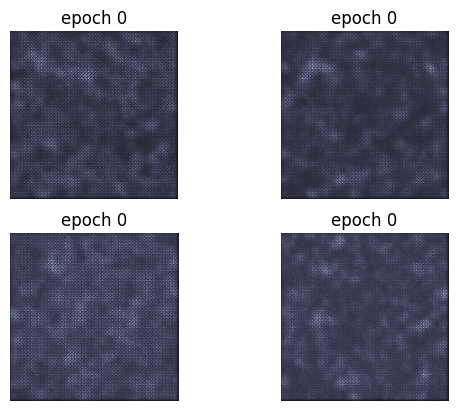

1/1 [==============================] - 0s 16ms/step
Epoch>2, Batch 1/5, d1=0.360, d2=0.667 g=0.735
1/1 [==============================] - 0s 16ms/step
Epoch>2, Batch 2/5, d1=0.152, d2=0.911 g=0.616
1/1 [==============================] - 0s 16ms/step
Epoch>2, Batch 3/5, d1=0.181, d2=1.702 g=0.459
1/1 [==============================] - 0s 16ms/step
Epoch>2, Batch 4/5, d1=0.162, d2=3.359 g=0.467
1/1 [==============================] - 0s 23ms/step
Epoch>2, Batch 5/5, d1=0.611, d2=0.767 g=3.243
1/1 [==============================] - 0s 68ms/step
Epoch>3, Batch 1/5, d1=1.010, d2=0.273 g=2.400
1/1 [==============================] - 0s 17ms/step
Epoch>3, Batch 2/5, d1=0.955, d2=0.614 g=0.798
1/1 [==============================] - 0s 17ms/step
Epoch>3, Batch 3/5, d1=0.937, d2=0.716 g=0.678
1/1 [==============================] - 0s 16ms/step
Epoch>3, Batch 4/5, d1=0.719, d2=0.727 g=0.673
1/1 [==============================] - 0s 16ms/step
Epoch>3, Batch 5/5, d1=0.650, d2=0.726 g=0.675
1/1 [=====

Epoch>51, Batch 5/5, d1=0.765, d2=0.589 g=0.843


1/1 [==============================] - 0s 100ms/step
Epoch 50, Average PSNR: 17.926


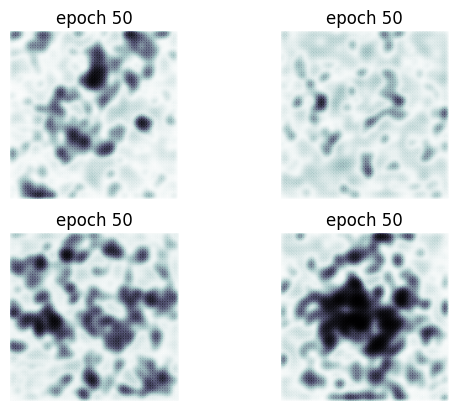

1/1 [==============================] - 0s 20ms/step
Epoch>52, Batch 1/5, d1=0.744, d2=0.742 g=0.750
1/1 [==============================] - 0s 17ms/step
Epoch>52, Batch 2/5, d1=0.741, d2=0.648 g=1.057
1/1 [==============================] - 0s 16ms/step
Epoch>52, Batch 3/5, d1=0.782, d2=0.574 g=0.899
1/1 [==============================] - 0s 16ms/step
Epoch>52, Batch 4/5, d1=0.802, d2=0.547 g=0.909
1/1 [==============================] - 0s 16ms/step
Epoch>52, Batch 5/5, d1=0.776, d2=0.557 g=0.883
1/1 [==============================] - 0s 27ms/step
Epoch>53, Batch 1/5, d1=0.734, d2=0.572 g=0.860
1/1 [==============================] - 0s 25ms/step
Epoch>53, Batch 2/5, d1=0.754, d2=0.601 g=0.834
1/1 [==============================] - 0s 16ms/step
Epoch>53, Batch 3/5, d1=0.693, d2=0.601 g=0.851
1/1 [==============================] - 0s 22ms/step
Epoch>53, Batch 4/5, d1=0.626, d2=0.584 g=0.894
1/1 [==============================] - 0s 17ms/step
Epoch>53, Batch 5/5, d1=0.736, d2=0.578 g=0.847


Epoch>101, Batch 5/5, d1=0.601, d2=0.403 g=1.216


1/1 [==============================] - 0s 108ms/step
Epoch 100, Average PSNR: 16.059


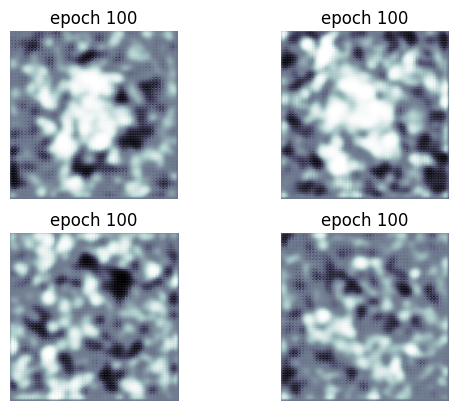

1/1 [==============================] - 0s 16ms/step
Epoch>102, Batch 1/5, d1=0.561, d2=0.947 g=0.670
1/1 [==============================] - 0s 16ms/step
Epoch>102, Batch 2/5, d1=0.606, d2=0.693 g=1.805
1/1 [==============================] - 0s 16ms/step
Epoch>102, Batch 3/5, d1=0.754, d2=0.402 g=1.647
1/1 [==============================] - 0s 29ms/step
Epoch>102, Batch 4/5, d1=0.787, d2=0.392 g=1.219
1/1 [==============================] - 0s 25ms/step
Epoch>102, Batch 5/5, d1=0.775, d2=0.421 g=1.200
1/1 [==============================] - 0s 16ms/step
Epoch>103, Batch 1/5, d1=0.663, d2=0.524 g=1.114
1/1 [==============================] - 0s 24ms/step
Epoch>103, Batch 2/5, d1=0.651, d2=0.802 g=0.801
1/1 [==============================] - 0s 26ms/step
Epoch>103, Batch 3/5, d1=0.735, d2=1.126 g=2.938
1/1 [==============================] - 0s 19ms/step
Epoch>103, Batch 4/5, d1=0.799, d2=0.546 g=0.972
1/1 [==============================] - 0s 16ms/step
Epoch>103, Batch 5/5, d1=0.817, d2=0.47

Epoch>151, Batch 5/5, d1=0.667, d2=0.445 g=1.396


1/1 [==============================] - 0s 96ms/step
Epoch 150, Average PSNR: 18.192


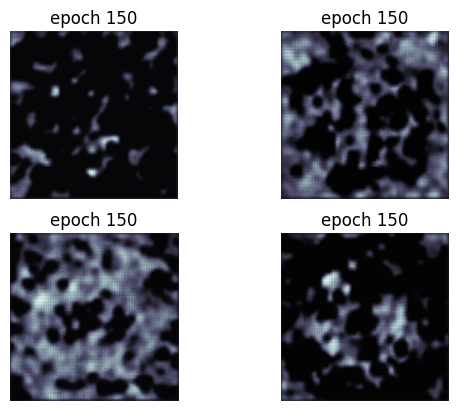

1/1 [==============================] - 0s 17ms/step
Epoch>152, Batch 1/5, d1=0.525, d2=0.565 g=1.011
1/1 [==============================] - 0s 17ms/step
Epoch>152, Batch 2/5, d1=0.563, d2=0.526 g=1.023
1/1 [==============================] - 0s 24ms/step
Epoch>152, Batch 3/5, d1=0.585, d2=0.532 g=0.968
1/1 [==============================] - 0s 23ms/step
Epoch>152, Batch 4/5, d1=0.517, d2=0.558 g=0.946
1/1 [==============================] - 0s 32ms/step
Epoch>152, Batch 5/5, d1=0.511, d2=0.577 g=0.942
1/1 [==============================] - 0s 16ms/step
Epoch>153, Batch 1/5, d1=0.412, d2=0.403 g=2.640
1/1 [==============================] - 0s 36ms/step
Epoch>153, Batch 2/5, d1=0.671, d2=0.568 g=1.038
1/1 [==============================] - 0s 16ms/step
Epoch>153, Batch 3/5, d1=0.502, d2=0.504 g=1.092
1/1 [==============================] - 0s 16ms/step
Epoch>153, Batch 4/5, d1=0.409, d2=0.526 g=1.071
1/1 [==============================] - 0s 16ms/step
Epoch>153, Batch 5/5, d1=0.529, d2=0.31

Epoch>201, Batch 5/5, d1=0.654, d2=0.704 g=0.732


1/1 [==============================] - 0s 102ms/step
Epoch 200, Average PSNR: 18.412


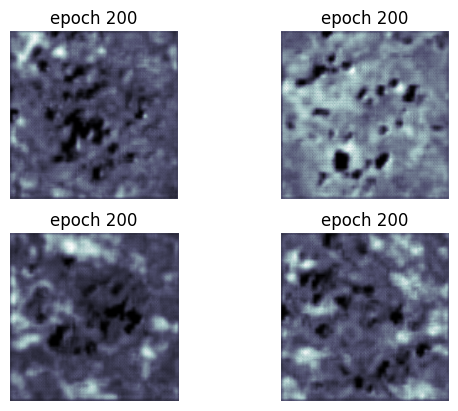

1/1 [==============================] - 0s 26ms/step
Epoch>202, Batch 1/5, d1=0.667, d2=0.713 g=0.734
1/1 [==============================] - 0s 29ms/step
Epoch>202, Batch 2/5, d1=0.662, d2=0.700 g=0.731
1/1 [==============================] - 0s 16ms/step
Epoch>202, Batch 3/5, d1=0.701, d2=0.705 g=0.728
1/1 [==============================] - 0s 17ms/step
Epoch>202, Batch 4/5, d1=0.705, d2=0.711 g=0.727
1/1 [==============================] - 0s 22ms/step
Epoch>202, Batch 5/5, d1=0.703, d2=0.706 g=0.734
1/1 [==============================] - 0s 16ms/step
Epoch>203, Batch 1/5, d1=0.690, d2=0.705 g=0.734
1/1 [==============================] - 0s 17ms/step
Epoch>203, Batch 2/5, d1=0.703, d2=0.698 g=0.741
1/1 [==============================] - 0s 18ms/step
Epoch>203, Batch 3/5, d1=0.667, d2=0.689 g=0.739
1/1 [==============================] - 0s 23ms/step
Epoch>203, Batch 4/5, d1=0.714, d2=0.689 g=0.771
1/1 [==============================] - 0s 23ms/step
Epoch>203, Batch 5/5, d1=0.727, d2=0.69

Epoch>251, Batch 5/5, d1=0.640, d2=0.704 g=0.761


1/1 [==============================] - 0s 95ms/step
Epoch 250, Average PSNR: 17.468


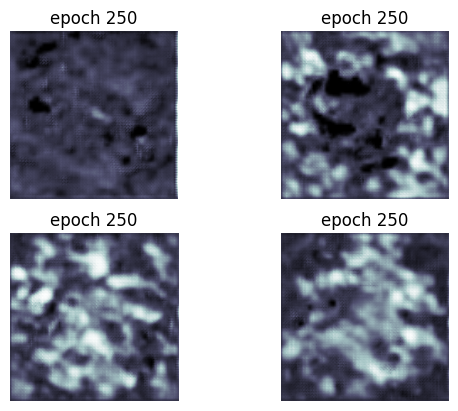

1/1 [==============================] - 0s 16ms/step
Epoch>252, Batch 1/5, d1=0.669, d2=0.685 g=0.741
1/1 [==============================] - 0s 16ms/step
Epoch>252, Batch 2/5, d1=0.672, d2=0.720 g=0.754
1/1 [==============================] - 0s 16ms/step
Epoch>252, Batch 3/5, d1=0.670, d2=0.685 g=0.766
1/1 [==============================] - 0s 16ms/step
Epoch>252, Batch 4/5, d1=0.671, d2=0.666 g=0.767
1/1 [==============================] - 0s 17ms/step
Epoch>252, Batch 5/5, d1=0.633, d2=0.751 g=0.800
1/1 [==============================] - 0s 26ms/step
Epoch>253, Batch 1/5, d1=0.697, d2=0.644 g=0.823
1/1 [==============================] - 0s 31ms/step
Epoch>253, Batch 2/5, d1=0.757, d2=0.619 g=0.764
1/1 [==============================] - 0s 16ms/step
Epoch>253, Batch 3/5, d1=0.667, d2=0.727 g=0.715
1/1 [==============================] - 0s 17ms/step
Epoch>253, Batch 4/5, d1=0.647, d2=0.722 g=0.743
1/1 [==============================] - 0s 16ms/step
Epoch>253, Batch 5/5, d1=0.631, d2=0.68

Epoch>301, Batch 5/5, d1=0.683, d2=0.673 g=0.822


1/1 [==============================] - 0s 145ms/step
Epoch 300, Average PSNR: 18.124


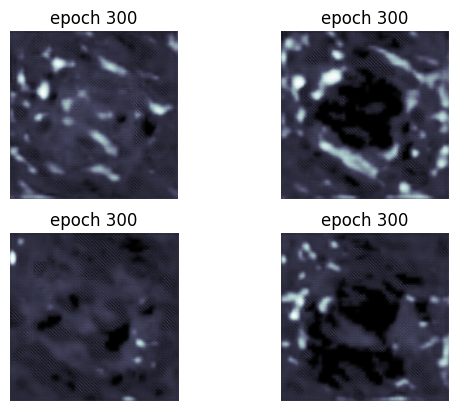

1/1 [==============================] - 0s 24ms/step
Epoch>302, Batch 1/5, d1=0.603, d2=0.621 g=0.886
1/1 [==============================] - 0s 17ms/step
Epoch>302, Batch 2/5, d1=0.695, d2=0.622 g=0.849
1/1 [==============================] - 0s 17ms/step
Epoch>302, Batch 3/5, d1=0.701, d2=0.621 g=0.824
1/1 [==============================] - 0s 17ms/step
Epoch>302, Batch 4/5, d1=0.602, d2=0.644 g=0.841
1/1 [==============================] - 0s 33ms/step
Epoch>302, Batch 5/5, d1=0.551, d2=0.624 g=0.845
1/1 [==============================] - 0s 24ms/step
Epoch>303, Batch 1/5, d1=0.643, d2=0.659 g=0.906
1/1 [==============================] - 0s 27ms/step
Epoch>303, Batch 2/5, d1=0.655, d2=0.611 g=0.860
1/1 [==============================] - 0s 41ms/step
Epoch>303, Batch 3/5, d1=0.690, d2=0.596 g=0.883
1/1 [==============================] - 0s 33ms/step
Epoch>303, Batch 4/5, d1=0.537, d2=0.674 g=0.859
1/1 [==============================] - 0s 16ms/step
Epoch>303, Batch 5/5, d1=0.566, d2=0.68

Epoch>351, Batch 5/5, d1=0.449, d2=0.963 g=2.660


1/1 [==============================] - 0s 96ms/step
Epoch 350, Average PSNR: 18.419


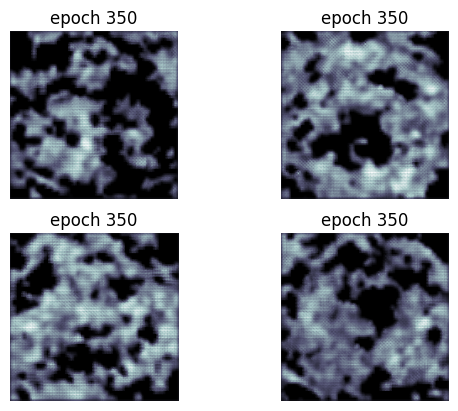

1/1 [==============================] - 0s 16ms/step
Epoch>352, Batch 1/5, d1=0.634, d2=0.847 g=0.924
1/1 [==============================] - 0s 16ms/step
Epoch>352, Batch 2/5, d1=0.576, d2=0.882 g=0.666
1/1 [==============================] - 0s 49ms/step
Epoch>352, Batch 3/5, d1=0.515, d2=0.809 g=0.828
1/1 [==============================] - 0s 38ms/step
Epoch>352, Batch 4/5, d1=0.307, d2=0.608 g=1.170
1/1 [==============================] - 0s 16ms/step
Epoch>352, Batch 5/5, d1=0.469, d2=0.535 g=1.178
1/1 [==============================] - 0s 16ms/step
Epoch>353, Batch 1/5, d1=0.395, d2=0.495 g=1.076
1/1 [==============================] - 0s 38ms/step
Epoch>353, Batch 2/5, d1=0.224, d2=0.470 g=1.131
1/1 [==============================] - 0s 16ms/step
Epoch>353, Batch 3/5, d1=0.265, d2=0.449 g=1.205
1/1 [==============================] - 0s 17ms/step
Epoch>353, Batch 4/5, d1=0.372, d2=0.422 g=1.284
1/1 [==============================] - 0s 16ms/step
Epoch>353, Batch 5/5, d1=0.393, d2=0.33

Epoch>401, Batch 5/5, d1=0.873, d2=0.683 g=0.775


1/1 [==============================] - 0s 102ms/step
Epoch 400, Average PSNR: 18.165


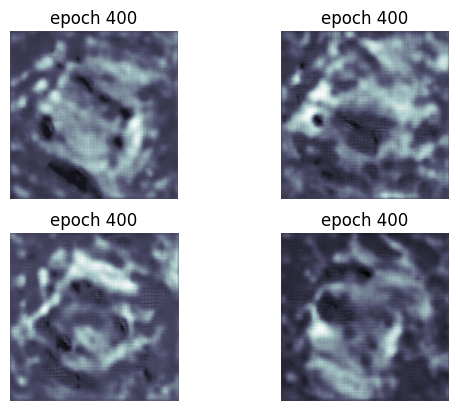

1/1 [==============================] - 0s 16ms/step
Epoch>402, Batch 1/5, d1=0.703, d2=0.679 g=0.786
1/1 [==============================] - 0s 17ms/step
Epoch>402, Batch 2/5, d1=0.625, d2=0.668 g=0.815
1/1 [==============================] - 0s 16ms/step
Epoch>402, Batch 3/5, d1=0.633, d2=0.676 g=0.804
1/1 [==============================] - 0s 16ms/step
Epoch>402, Batch 4/5, d1=0.666, d2=0.746 g=0.788
1/1 [==============================] - 0s 23ms/step
Epoch>402, Batch 5/5, d1=0.707, d2=0.769 g=0.973
1/1 [==============================] - 0s 30ms/step
Epoch>403, Batch 1/5, d1=0.753, d2=0.591 g=0.981
1/1 [==============================] - 0s 21ms/step
Epoch>403, Batch 2/5, d1=0.812, d2=0.670 g=0.801
1/1 [==============================] - 0s 21ms/step
Epoch>403, Batch 3/5, d1=0.709, d2=0.707 g=0.766
1/1 [==============================] - 0s 16ms/step
Epoch>403, Batch 4/5, d1=0.641, d2=0.708 g=0.765
1/1 [==============================] - 0s 16ms/step
Epoch>403, Batch 5/5, d1=0.603, d2=0.66

Epoch>451, Batch 5/5, d1=0.103, d2=0.051 g=3.165


1/1 [==============================] - 0s 102ms/step
Epoch 450, Average PSNR: 19.512


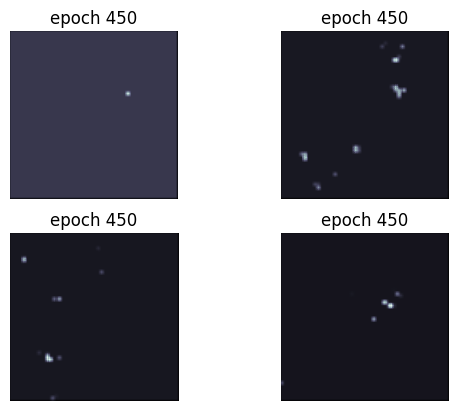

1/1 [==============================] - 0s 16ms/step
Epoch>452, Batch 1/5, d1=0.061, d2=0.056 g=3.259
1/1 [==============================] - 0s 22ms/step
Epoch>452, Batch 2/5, d1=0.062, d2=0.054 g=3.207
1/1 [==============================] - 0s 16ms/step
Epoch>452, Batch 3/5, d1=0.024, d2=0.050 g=3.196
1/1 [==============================] - 0s 16ms/step
Epoch>452, Batch 4/5, d1=0.033, d2=0.031 g=3.969
1/1 [==============================] - 0s 16ms/step
Epoch>452, Batch 5/5, d1=0.101, d2=0.070 g=3.381
1/1 [==============================] - 0s 44ms/step
Epoch>453, Batch 1/5, d1=0.023, d2=0.081 g=3.585
1/1 [==============================] - 0s 16ms/step
Epoch>453, Batch 2/5, d1=0.140, d2=0.078 g=3.429
1/1 [==============================] - 0s 20ms/step
Epoch>453, Batch 3/5, d1=0.281, d2=0.257 g=4.072
1/1 [==============================] - 0s 16ms/step
Epoch>453, Batch 4/5, d1=0.042, d2=0.017 g=4.492
1/1 [==============================] - 0s 23ms/step
Epoch>453, Batch 5/5, d1=0.552, d2=0.47

Epoch>501, Batch 5/5, d1=0.276, d2=0.537 g=2.437


1/1 [==============================] - 0s 98ms/step
Epoch 500, Average PSNR: 18.854


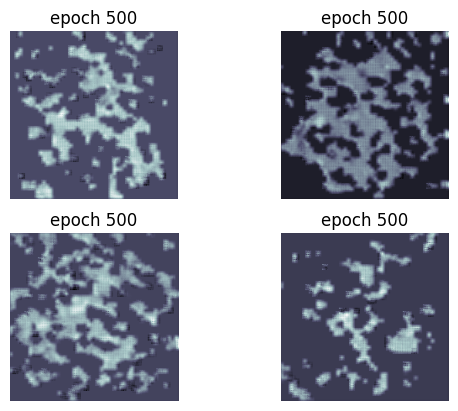

1/1 [==============================] - 0s 17ms/step
Epoch>502, Batch 1/5, d1=0.201, d2=0.129 g=2.679
1/1 [==============================] - 0s 17ms/step
Epoch>502, Batch 2/5, d1=0.201, d2=0.104 g=2.690
1/1 [==============================] - 0s 16ms/step
Epoch>502, Batch 3/5, d1=0.148, d2=0.166 g=2.578
1/1 [==============================] - 0s 17ms/step
Epoch>502, Batch 4/5, d1=0.464, d2=0.404 g=2.347
1/1 [==============================] - 0s 16ms/step
Epoch>502, Batch 5/5, d1=0.091, d2=0.346 g=3.497
1/1 [==============================] - 0s 27ms/step
Epoch>503, Batch 1/5, d1=0.361, d2=1.902 g=5.607
1/1 [==============================] - 0s 28ms/step
Epoch>503, Batch 2/5, d1=2.800, d2=0.042 g=3.373
1/1 [==============================] - 0s 39ms/step
Epoch>503, Batch 3/5, d1=0.450, d2=1.552 g=2.370
1/1 [==============================] - 0s 17ms/step
Epoch>503, Batch 4/5, d1=0.579, d2=0.571 g=4.169
1/1 [==============================] - 0s 17ms/step
Epoch>503, Batch 5/5, d1=1.191, d2=0.45

Epoch>551, Batch 5/5, d1=0.408, d2=0.420 g=1.451


1/1 [==============================] - 0s 141ms/step
Epoch 550, Average PSNR: 18.097


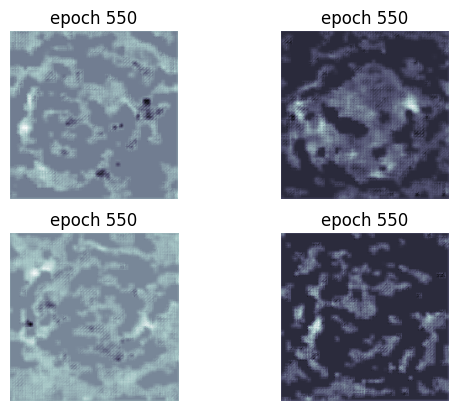

1/1 [==============================] - 0s 23ms/step
Epoch>552, Batch 1/5, d1=0.516, d2=0.477 g=1.314
1/1 [==============================] - 0s 16ms/step
Epoch>552, Batch 2/5, d1=0.464, d2=0.528 g=1.211
1/1 [==============================] - 0s 18ms/step
Epoch>552, Batch 3/5, d1=0.440, d2=0.481 g=1.258
1/1 [==============================] - 0s 16ms/step
Epoch>552, Batch 4/5, d1=0.516, d2=0.524 g=1.261
1/1 [==============================] - 0s 17ms/step
Epoch>552, Batch 5/5, d1=0.327, d2=0.491 g=1.449
1/1 [==============================] - 0s 23ms/step
Epoch>553, Batch 1/5, d1=0.427, d2=0.431 g=1.596
1/1 [==============================] - 0s 20ms/step
Epoch>553, Batch 2/5, d1=0.737, d2=0.563 g=1.220
1/1 [==============================] - 0s 23ms/step
Epoch>553, Batch 3/5, d1=0.387, d2=0.619 g=1.674
1/1 [==============================] - 0s 26ms/step


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.models import load_model

# Assuming you have defined the following functions:
# real_samples, fake_samples, generate_latent_points, func_discriminator, func_generator, gan, show_plot

psnr_values_list = []

def func_train(gen_model, dis_model, gan_model, dataset, noise_dimension, num_epochs=1000, num_batch=64, augmentation_prob=0.6):
    batch_per_epoch = int(dataset.shape[0] / num_batch)
    half_batch = int(num_batch / 2)

    datagen = ImageDataGenerator(rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

    for i in range(num_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = real_samples(dataset, half_batch)

            # Apply adaptive data augmentation with probability
            if np.random.rand() < augmentation_prob:
                X_real = datagen.flow(X_real, batch_size=half_batch, shuffle=False).next()

            d_loss_real, d_acc_real = dis_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = fake_samples(gen_model, noise_dimension, half_batch)
            d_loss_fake, d_acc_fake = dis_model.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(noise_dimension, num_batch)
            y_gan = np.ones((num_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, batch_per_epoch, d_loss_real, d_loss_fake, g_loss))

        if i % 50 == 0:
            checkpoint_path = '/content/drive/MyDrive/gan_checkpoints/Chkpt_{}.h5'.format(i)
            gen_model.save(checkpoint_path)
            model = load_model(checkpoint_path)

            # Generate samples for PSNR calculation
            latent_points = generate_latent_points(100, 4)
            generated_images = model.predict(latent_points)

            # Rescale generated images from [-1, 1] to [0, 1]
            generated_images = (generated_images + 1) / 2.0

            # Calculate PSNR for each generated image
            psnr_values = [peak_signal_noise_ratio(X_train[idx], generated_images[idx]) for idx in range(len(generated_images))]

            # Append the average PSNR to the list
            avg_psnr = np.mean(psnr_values)
            psnr_values_list.append(avg_psnr)

            # Print the average PSNR value
            print(f'Epoch {i}, Average PSNR: {avg_psnr:.3f}')
            show_plot(generated_images, 2, i)

dis_model = func_discriminator()
gen_model = func_generator(noise_dimension)
gan_model = gan(gen_model, dis_model)
dataset = X_train
func_train(gen_model, dis_model, gan_model, dataset, noise_dimension)


In [ ]:
import numpy as np
from keras.models import load_model
from numpy.random import randn

# generate points
def generate_latent_points(noise_dimension, n_samples):
    x_input = randn(noise_dimension * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, noise_dimension)
    return x_input

good_chkpt = [300]

for chkpt in good_chkpt:
    model_path = '/content/drive/MyDrive/gan_checkpoints/Chkpt_{}.h5'.format(chkpt)

    # Check if the file exists
    if not os.path.exists(model_path):
        print(f"File not found: {model_path}")
        continue

    model = load_model(model_path)

    lp = generate_latent_points(100, 200)
    X = model.predict(lp)

    from scipy.io import savemat
    # Transpose the dimensions
    transposed_array = np.transpose(X, (2, 1, 0, 3))[:,:,:,0]
    print(transposed_array.shape)

    # Save the transposed array as a .mat file within Colab environment
    mat_file_path = '/content/SpectralADAResidual_{}.mat'.format(chkpt)
    savemat(mat_file_path, {'data': transposed_array})
    print(f'MAT file saved: {mat_file_path}')
